In [165]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal
from numpy import random
from pytransit import QuadraticModel
from tabulate import tabulate


##y is flux, x is time
x_value = np.array([])
y_value = np.array([])
noise_array = np.array([])
depth_match = np.array([])
period_match = np.array([])


rand_period = random.rand()
rand_depth = random.rand()
print(rand_period)

0.2125661729931293


In [166]:
#timesteps = int(input("Number of timesteps: "))
timesteps =  19440 # minutes in 27 days divided by 2
depth = 1 - (rand_depth * .02)
time = list(range(1,timesteps+1)) 
transit_length = list(range(1,121))
transit_frequency = 5760 + (rand_period * 1400)

for timestep in time:
    n=0
    minute_value = timestep * 2
    x_value = np.append(x_value, minute_value)
    noise = random.normal(0,.002)
    if minute_value % transit_frequency < 2:
        while n <= (len(transit_length) / 2) and len(y_value) < timesteps:
            transit_with_noise = depth #+ noise
            y_value = np.append(y_value, transit_with_noise)
            n = n+1
    elif len(y_value) < timesteps:
        gaussian_noise = 1 #+ noise
        y_value = np.append(y_value, gaussian_noise)


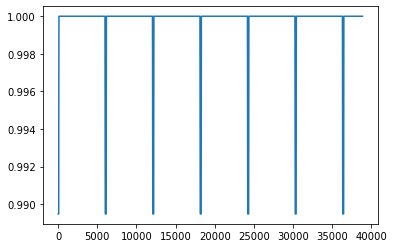

In [167]:
time_pytransit = np.linspace(0,27,19441)

def model(period,rp_over_rstar,a_over_rstar,inc,ecc,omega):
    """
    Function for computing transit models for the set of 8 free paramters
    x - time array
    """
    tm = QuadraticModel()
    tm.set_data(time_pytransit)
    i=inc/180.0*np.pi
    w=omega/180.0*np.pi
    lightcurve=tm.evaluate(k=rp_over_rstar, ldc=[0.0,0.0], t0=0.0, p=period, a=a_over_rstar, i=i,e=ecc,w=w)
    return lightcurve

lc=model(4. + rand_period,.1 +.02 *rand_depth,12.306,90.,0.,0.) #must find relationship between depth and rp_over_rstar
time_mins = time_pytransit * 1440
plt.plot(time_mins, lc)
plt.show()

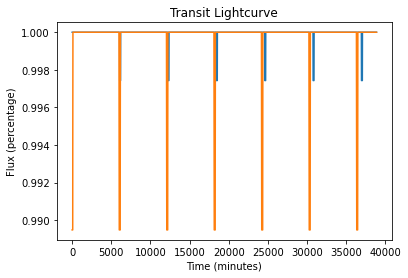

In [168]:
fig = plt.figure()
plt.plot(x_value, y_value)
plt.plot(time_mins, lc)
plt.xlabel("Time (minutes)")
plt.ylabel("Flux (percentage)")
plt.title("Transit Lightcurve")
plt.show()

In [54]:
unknown_transit = np.column_stack((x_value, y_value))
periods = np.array([])
depths = np.array([])
chis = np.array([])

period_range = np.linspace(5760,7200,11)
depth_range = np.linspace(.98,1,11)

for period in period_range:
    for depth in depth_range:
        comparison_x_value = np.array([]) # the arrays must be cleared every time
        comparison_y_value = np.array([])
        periods = np.append(periods, period) # retrieve period
        depths = np.append(depths, depth)    # retrieve depth
        for timestep in time: # make graph to compare to, same code as before
            n=0
            minute_value = timestep * 2
            comparison_x_value = np.append(comparison_x_value, minute_value)
            if minute_value % period < 2:
                while n <= (len(transit_length) / 2) and len(comparison_y_value) < timesteps:
                    transit_with_noise = depth
                    comparison_y_value = np.append(comparison_y_value, transit_with_noise)
                    n = n+1
            elif len(comparison_y_value) < timesteps:
                base_flux = 1
                comparison_y_value = np.append(comparison_y_value, base_flux)
        #comparison_transit = np.column_stack((comparison_x_value, comparison_y_value)) #not needed for this
        flux_comparison = np.column_stack((y_value, comparison_y_value))
        error_calc_indi = 0 # must be reset every time too
        error_calc_total = 0
        for pair in flux_comparison: # compare idealized data with actual
            error_calc_indi = ((pair[0] - pair[1]) ** 2) / (.002 ** 2)
            error_calc_total = error_calc_total + error_calc_indi
        chi_indi = error_calc_total / 19400
        chis = np.append(chis, chi_indi) # retrieve chi

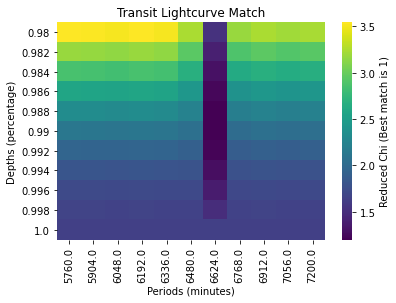

    Depths (percentage)  Periods (minutes)  Reduced Chi (Best match is 1)
71                 0.99             6624.0                       1.196268


In [60]:
data = pd.DataFrame({'Depths (percentage)': depths, 'Periods (minutes)': periods, 'Reduced Chi (Best match is 1)': chis})
data_pivoted = data.pivot("Depths (percentage)", "Periods (minutes)", "Reduced Chi (Best match is 1)")
data_pivoted = sns.heatmap(data_pivoted, cmap="viridis")
plt.title("Transit Lightcurve Match")
data_pivoted.collections[0].colorbar.set_label("Reduced Chi (Best match is 1)")
plt.show()

#print(tabulate(data, headers='keys', tablefmt='psql'))
min_chi = data['Reduced Chi (Best match is 1)'].idxmin()
print(data.loc[[min_chi]])


In [56]:
#vectorized way
        #error_calc = ((flux_comparison[:,0] - flux_comparison[:,1]) ** 2) / (.002 ** 2)
        #print(len(error_calc))